In [148]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch

## Data Loading & Processing
* Load and normalize sensor data

In [866]:
df = pd.read_csv('turbofan.csv')
df[df.columns[5:]] = (df[df.columns[5:]] - df[df.columns[5:]].mean())/df[df.columns[5:]].std()
df.head()

,unit_number,time,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,0.999976,-1.721684,-0.134252,-0.925914,0.999976,...,0.334254,-1.058865,-0.269065,-0.603801,0.999976,-0.781691,NaN,NaN,1.348460,1.194398
1,1,2,0.0019,-0.0003,100.0,0.999976,-1.061754,0.211523,-0.643710,0.999976,...,1.174871,-0.363637,-0.642829,-0.275845,0.999976,-0.781691,NaN,NaN,1.016503,1.236892
2,1,3,-0.0043,0.0003,100.0,0.999976,-0.661797,-0.413156,-0.525940,0.999976,...,1.364688,-0.919819,-0.551616,-0.649128,0.999976,-2.073044,NaN,NaN,0.739873,0.503411
3,1,4,0.0007,0.0000,100.0,0.999976,-0.661797,-1.261284,-0.784812,0.999976,...,1.961255,-0.224592,-0.520163,-1.971617,0.999976,-0.781691,NaN,NaN,0.352590,0.777773
4,1,5,-0.0019,-0.0002,100.0,0.999976,-0.621801,-1.251498,-0.301511,0.999976,...,1.052846,-0.780774,-0.521736,-0.339837,0.999976,-0.136014,NaN,NaN,0.463242,1.059526


## Data Cleaning
* Remove column with more than a certain % of nans 

In [867]:
nan_threshold = 0.8
nan_cols = df.columns[df.isna().sum() >= int(len(df)*nan_threshold)]
new_cols = [c for c in list(df.columns) if c not in list(nan_cols)]
sensors_count = 0
for c in new_cols:
    sensors_count+= 1 if 'sensor' in c else 0
data = df[new_cols]
print('after cleaning: {} sensors remain'.format(sensors_count))

after cleaning: 19 sensors remain


### Visualizing units
* There's a visible convergence followed by divergence of sensor measurements ~60 cycles before failure
* There are some big dips in the brown signal, it could be noise but it might be telling us something so I kept it.

In [868]:
def get_unit_data(data, x):
    return data.loc[data['unit_number']==x, data.columns[5:]]

In [870]:
units

array([80,  8, 32, 34])

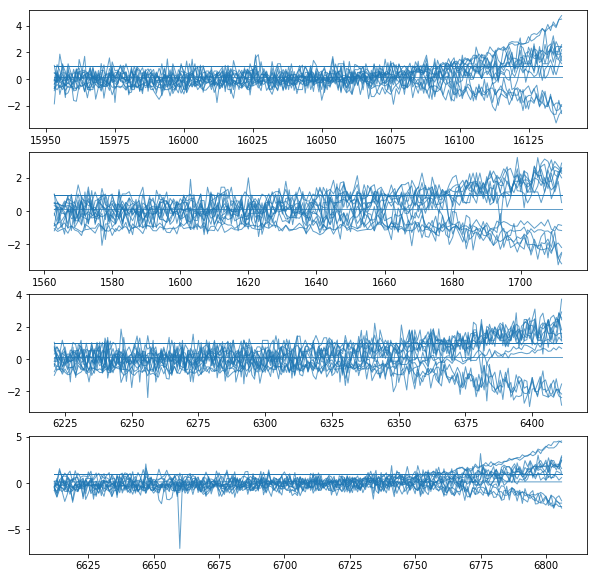

In [869]:
N = 4
fig, axs = plt.subplots(N, 1, figsize=(10,N*2.5))
units = np.random.choice(100, N, replace=False)
for i in range(N):
    get_unit_data(data, units[i]).plot(ax=axs[i], legend=None, color='C0', linewidth=1, alpha=0.7)

### Choosing portions of relevant data
* Data way before the failure might not be necessary.
* Based on visualization and the min. time cycles, I choose to look at 60 time cycles before failure (or the min. time cycles in a simulation, whichever is lower)

In [216]:
lens = []
for i in range(1,101):
    lens.append(len(df.loc[df['unit_number']==i]))
print("avg duration (time cycles): {} \nmin duration (time cycles): {}".format(sum(lens)/100, min(lens)))

# relevant_time is how much data before the failure is considered
relevant_time = min(60, min(lens))
print("relevant window chosen: {}".format(relevant_time))

avg duration (time cycles): 206.31 
min duration (time cycles): 128
relevant window chosen: 60


## Create dataset
* Split units into train, val and test
* Data-label pair are created using window size of 24 with stride 3.
* See below for labelling details.

In [217]:
np.random.seed(1)
unit_count = data['unit_number'].nunique()
perm = np.random.permutation(unit_count)+1
split = [60,20,20]
train_idx = perm[:split[0]]
val_idx = perm[split[0]:split[0]+split[1]]
test_idx = perm[split[0]+split[1]:]

train_raw = data[data['unit_number'].isin(train_idx)]#[data.columns[5:]]
val_raw = data[data['unit_number'].isin(val_idx)]
test_raw = data[data['unit_number'].isin(test_idx)]
print('total units:{}, train:{}, val:{}, test:{}'.format(unit_count, *split))

total units:100, train:60, val:20, test:20


### Crop sensor measurements into windows of a specific time cycles

In [218]:
def scale(l):
    l = l - np.min(l)
    return l/np.max(l)

def get_windows(d, width, stepsize, relevant_time):
    assert width >= stepsize, "width should be >= stepsize"
    assert relevant_time <= len(d) - width, "relevant_time should <= (len(d) - width), the total time"
    assert relevant_time >= 15, "relevant_time should <= (len(d) - width), the total time"
    
    relevant_steps = int(np.ceil(relevant_time/stepsize))
    n = len(d)
    mod = n % stepsize
    window_idx = np.array([list(range(x+mod, x+width+mod)) for x in range(0, n-width+1, stepsize)])
    
    # windows of data are used as training samples
    X = d.values[window_idx]
    y = np.zeros(X.shape[0])
    
    # labels: create quadratic increase to 1 before the last 15 cycles, and 1 for the last 15 cycles
    last15 = int(15/stepsize)
    y[-last15:] = 1
    y[-relevant_steps:-last15] = scale(np.square(np.linspace(0,relevant_time-15, int(relevant_steps-last15))))
    return X,y

def create_data_windows(data_idx, data_raw, width, stepsize, relevant_time):
    X_list, y_list = [], []
    for i in data_idx:
        unit_data = data_raw.loc[data_raw['unit_number']==i]
        d = unit_data[unit_data.columns[5:]]
        wX, wy = get_windows(d, width, stepsize, relevant_time)
        X_list.append(wX)
        y_list.append(wy)
    return X_list, y_list

def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def list2np(X_list, y_list):
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return unison_shuffle(X, y)

### Convert data to torch tensor

In [219]:
width = 24 # cycles in a window
stepsize = 3
X_train_list, y_train_list = create_data_windows(train_idx, train_raw, width, stepsize, relevant_time)
X_val_list,   y_val_list   = create_data_windows(val_idx, val_raw, width, stepsize, relevant_time)
X_test_list,  y_test_list  = create_data_windows(test_idx, test_raw, width, stepsize, relevant_time)

X_train, y_train = list2np(X_train_list, y_train_list)
X_val, y_val = list2np(X_val_list, y_val_list)
X_test, y_test = list2np(X_test_list, y_test_list)

device = torch.device("cpu")#torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
X_val = torch.tensor(X_val).float().to(device)
y_val = torch.tensor(y_val).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

### Labels
* 0 - 15 cycles before failure: 1
* 15 - 80 cycles: quadratic decay
* 80+ cycles: 0

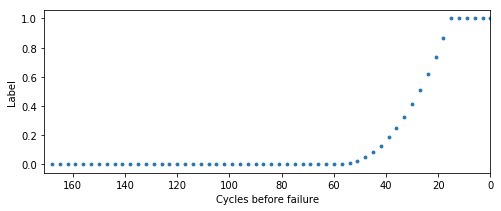

In [552]:
plt.figure(figsize=(8,3))
demo_label = np.sort(y_test_list[0])[::-1]
plt.scatter(x=np.array(range(len(demo_label)))*3, y=demo_label, s=8);
plt.xlim(len(demo_label)*3,0)
plt.xlabel('Cycles before failure');
plt.ylabel('Label');

---
## Model Development
### Architecture
* A 3-layer NN with a dropout, ReLU and finally a sigmoid layer is used

In [221]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

input_size = 19*width
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.fc2 = nn.Linear(4, 1)
        self.drop = nn.Dropout(p=0.1)

    def forward(self, x):
        # flatten inputs
        x = x.reshape(-1,input_size)
        
        # 2-layer NN
        x = self.drop(self.fc1(x))
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        x = torch.squeeze(x,dim=0)
        return x

### Training
* Adam optimizer, 50 epochs
* Mean square error + extra weight as cycles get closer to 15
* Takes about 5 min (no GPU needed)

In [260]:
net = Net().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-4) 

train_loss_list, val_loss_list = [],[]
best_weights = []
best_epoch = 0

for epoch in range(50):
    # create a random 50% subset of training data every epoch
    subset = 0.5
    idx = torch.randperm(X_train.size(0))
    X_train_subset = X_train[idx[:int(len(idx)*subset)],...]
    y_train_subset = y_train[idx[:int(len(idx)*subset)],...]
    
    running_loss = 0.0
    i = 0
    for inputs, labels in zip(X_train_subset,y_train_subset):
        i+=1
        inputs = torch.unsqueeze(inputs, dim=0).permute(0,2,1).float()
        labels = labels.unsqueeze(dim=0)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)*((labels+1)**4)
        loss.backward()
        optimizer.step()        
        running_loss += loss.item()
    
    train_loss = running_loss/i
    train_loss_list.append(train_loss)

    # validation
    val_outputs = net.eval()(X_val.permute(0,2,1).float())
    val_labels = y_val.unsqueeze(dim=1)
    val_loss = torch.mean(criterion(val_outputs, val_labels)*((val_labels+1)**4))
    val_loss_list.append(float(val_loss.data)) 
        
    # store best weight
    if len(val_loss_list) > 1:
        if (val_loss.item() < min(val_loss_list[:-1])):
            best_weights = net.state_dict()
            best_epoch = epoch
    
    if epoch % 5 == 0:        
        print('[epoch #%s, best #%s] loss: %.5f, val_loss: %.5f' % (str(epoch).zfill(3), str(best_epoch).zfill(3), train_loss, val_loss))
    
print('Finished Training')

[epoch #000, best #000] loss: 0.21064, val_loss: 0.11077
[epoch #005, best #005] loss: 0.04118, val_loss: 0.04880
[epoch #010, best #010] loss: 0.02584, val_loss: 0.02740
[epoch #015, best #015] loss: 0.02054, val_loss: 0.02717
[epoch #020, best #020] loss: 0.01834, val_loss: 0.02438
[epoch #025, best #023] loss: 0.01682, val_loss: 0.02491
[epoch #030, best #023] loss: 0.01646, val_loss: 0.02699
[epoch #035, best #023] loss: 0.01631, val_loss: 0.02804
[epoch #040, best #036] loss: 0.01526, val_loss: 0.02067
[epoch #045, best #036] loss: 0.01612, val_loss: 0.02741
Finished Training


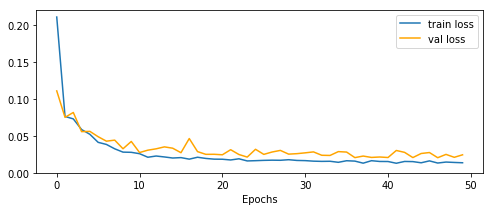

In [261]:
plt.figure(figsize=(8,3))
plt.plot(train_loss_list, label='train loss');
plt.plot(val_loss_list, c='orange', label='val loss');
plt.legend()
plt.xlabel('Epochs');
plt.ylim(0);

In [264]:
# save best model
weights_name = "best_weights_{}".format(time.strftime("%m%d-%H:%M:%S"))
torch.save(best_weights, weights_name)

In [265]:
# load saved weights
net.load_state_dict(torch.load(weights_name))

<All keys matched successfully>

## Predictions
### On *all* validation data (sorted by labels, not a time-series)

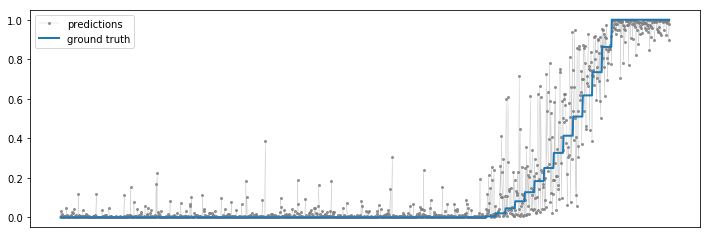

In [889]:
outs = net.eval()(X_val.permute(0,2,1).float()).cpu() 
arg = np.argsort(y_val.cpu())
plt.figure(figsize=(12,4))
plt.plot(outs.detach().numpy()[arg], color='gray', linewidth=0.2, marker='o', markersize=2, label='predictions', alpha=0.8)
plt.plot(np.sort(y_val.cpu()), linewidth=2, label='ground truth')
plt.legend(); plt.xticks([],[]);

### On *all* test data (sorted by labels, not a time-series)

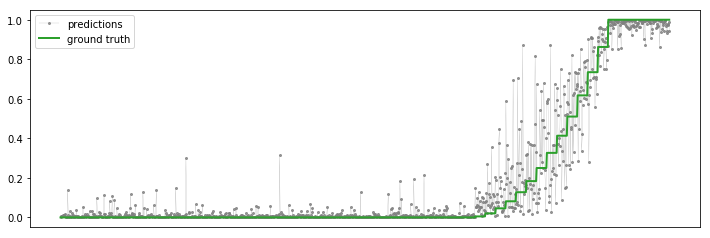

In [890]:
outs = net.eval()(X_test.permute(0,2,1).float()).cpu() 
arg = np.argsort(y_test.cpu())
plt.figure(figsize=(12,4));
plt.plot(outs.detach().numpy()[arg], color='gray', linewidth=0.2, marker='o', markersize=2, label='predictions', alpha=0.8);
plt.plot(np.sort(y_test.cpu()), color='C2', linewidth=2, label='ground truth');
plt.legend(); plt.xticks([],[]);

---
## Deployment
### Predictions on actual time-series

In [435]:
def get_windows_for_inference(d, width, stepsize, relevant_time):
    relevant_steps = int(np.ceil(relevant_time/stepsize))
    n = len(d)
    mod = n % stepsize
    window_idx = np.array([list(range(x+mod, x+width+mod)) for x in range(0, n-width+1, stepsize)])
    X = d.values[window_idx]
    y = np.zeros(X.shape[0])
    y[-int(15/stepsize):] = 1
    y = np.sort(np.concatenate([np.zeros(width)]+[y]*stepsize))
    return X,y

def fill_steps(uy, width,stepsize):
    new_uy = np.zeros(len(uy)*stepsize+width)
    new_uy[width:][::stepsize] = uy
    return new_uy

def fill_x(upred, width, stepsize):
    return [x*stepsize + width for x in range(len(upred))]
    
def run_inference(net, uX):
    return np.squeeze(net.eval()(torch.tensor(uX).permute(0,2,1).float().to(device)).detach().numpy())

#### Run the below code to visualize prediction on a random test unit

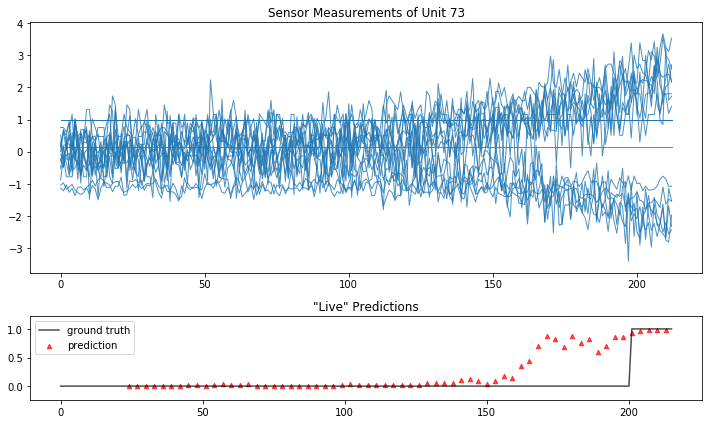

In [881]:
unit_number = np.random.choice(test_idx)

# perform inference
unit_data = get_unit_data(data,unit_number).reset_index(drop=True)
uX, uy = get_windows_for_inference(unit_data, width, stepsize, relevant_time)
upred = run_inference(net, uX)

# plot predictions
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
unit_data.plot(ax=axs[0],legend=None, figsize=(10,6), color='C0', linewidth=1, alpha=0.8);
axs[0].title.set_text('Sensor Measurements of Unit {}'.format(unit_number))

# plt.scatter(x=range(len(uy)), y=uy, color='k', marker=0,label='ground truth', alpha=0.5, s=99)
plt.plot(uy, color='k', label='ground truth', alpha=0.7)
plt.scatter(x=fill_x(upred, width, stepsize), y=upred, color='red', marker='^',s=20, label='prediction', alpha=0.7)
axs[1].title.set_text('\"Live\" Predictions'.format(unit_number))
plt.legend(); plt.margins(None,0.2);
plt.tight_layout()

### Getting the final outputs using thresholding
* The predictions ranges from [0,1]
* The algorithm needs a threshold to notify failure in the next 15 cycles.

### Obtaining the threshold
* The algorithm raises a warning when the threshold exceed **after *buffer* times** (default = 0).
* I'll assign different costs for early warnings (>15 cycles prior) and late warnings (<15 cycles prior)
* The cost will help me to optimize the threshold, using data for

In [837]:
def get_warning_cost(unit_number, threshold):
    buffer = 0
    unit_data = get_unit_data(data,unit_number).reset_index(drop=True)
    uX, uy = get_windows_for_inference(unit_data, width, stepsize, relevant_time)
    upred = run_inference(net, uX)
    if len(np.nonzero(upred > threshold)[0]) > buffer:
        warning_cycle = len(unit_data) - (np.nonzero(upred > threshold)[0][buffer]*stepsize + width)
    else:
        warning_cycle = 0
    cost = (warning_cycle-15)*early_cost if warning_cycle>15 else (15-warning_cycle)*late_cost
    return warning_cycle, cost

In [840]:
early_cost = 0.3
late_cost = 1

threshold_range = np.linspace(0.7,1,31)
threshold_costs = []

for threshold in threshold_range:
    costs = []
    for unit_number in val_idx:
        warning_cycle, cost = get_warning_cost(unit_number, threshold)
        costs.append(cost)
    
    threshold_costs.append(sum(costs)/len(costs))

best_threshold = np.round(threshold_range[np.argmin(threshold_costs)],5)
print('Threshold to be used: {}'.format(best_threshold))

Threshold to be used: 0.87


## Results on test data units
* Putting everything together, let's see how the algorithm performs on data it has never seen before.

In [843]:
test_warnings = []
test_costs = []
for unit_number in test_idx:
    warning_cycle, cost = get_warning_cost(unit_number, best_threshold)
    test_warnings.append(warning_cycle)
    test_costs.append(cost)
    
test_warnings = np.array(test_warnings)
early_warnings = np.sort(test_warnings[test_warnings >= 15])
late_warnings = np.sort(test_warnings[test_warnings < 15])
test_cost = sum(test_costs)/len(test_costs)

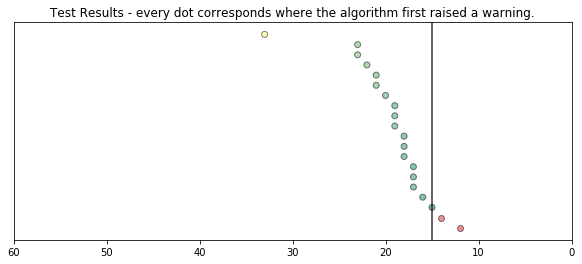

In [844]:
late = len(late_warnings)
plt.figure(figsize=(10,4))
plt.xlim(max(max(test_warnings),relevant_time), 0); plt.ylim(0.5,9.5); plt.yticks([],[]);
plt.bar(x=15, height=10, width=0.2, color='k', alpha=0.6)
plt.title('Test Results - every dot corresponds where the algorithm first raised a warning.')

plt.scatter(x=early_warnings, y=[x/(len(test_warnings)-1)*8+1 for x in range(len(test_warnings))][late:],
            c=early_warnings, alpha=0.5, cmap='summer', linewidth=1, edgecolors='k');
plt.scatter(x=late_warnings, y=[x/(len(test_warnings)-1)*8+1 for x in range(len(test_warnings))][:late],
            c='C3', alpha=0.5, linewidth=1, edgecolors='k');

### Final Results

In [856]:
print('Warnings: {} ± {} (Cycles before failure)'.format(np.mean(test_warnings), np.round(np.std(test_warnings),1)))

Warnings: 19.1 ± 4.2 (Cycles before failure)
